In [1]:
if (!require("pacman")) install.packages("pacman")
p_load(data.table, ggplot2, dplyr, scales, caret, googledrive, ggpubr, tidyr, cowplot)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

In [2]:
drive_download(file = as_id("https://drive.google.com/open?id=1cojd2hT5QFTc9Qabyd3vJnpl4uiU--n9"),
  path = "Pubs_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1uAwZfZ_0RKO4tvqIbXQqMNq2MuKmexup"),
  path = "Comp_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1p47VtjOC87uB33ZOWJqidYort9suOHFv"),
  path = "PubsCited_Final.csv",
  overwrite = TRUE)

drive_download(file = as_id("https://drive.google.com/open?id=1qUoBDeKDqHXEvcXQiEmYia94Ra03J2nm"),
  path = "CompCited_Sample_Final.csv",
  overwrite = TRUE)

pubs = fread("Pubs_Final.csv", encoding = "UTF-8", stringsAsFactors = F)
comp = fread("Comp_Final.csv", encoding = "UTF-8", stringsAsFactors = F)
pubs_cited = fread("PubsCited_Final.csv", encoding = "UTF-8", stringsAsFactors = F)
comp_cited = fread("CompCited_Sample_Final.csv", encoding = "UTF-8", stringsAsFactors = F)
full_data = rbind(pubs[,-25], comp)

In [3]:
head(full_data)

scopus_id,eid,title,publication_name,issn,isbn,eissn,volume,issue,page_range,...,auth_keywords,fund_acr,fund_no,fund_sponsor,full_text,Field,Dataset,Quartile,query,CiteScore
<int64>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
84889092764,2-s2.0-84889092764,The social-ecological system framework as a knowledge classificatory system for benthic small-scale fisheries,Global Environmental Change,9593780,NA,,23,6,1366-1380,...,Benthic small-scale fisheries | Chile | Human dimensions | Mexico | Social-ecological system (SES) framework,,undefined,Duke University,https://api.elsevier.com/content/article/eid/1-s2.0-S0959378013001350,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Global Environmental Change) AND VOLUME(23) AND ISSUE(6),10.29
84891884316,2-s2.0-84891884316,Cooperative and noncooperative strategies for small-scale fisheries' self-governance in the globalization era: Implications for conservation,Ecology and Society,,NA,17083087,18,4,,...,Commercialization | Fishing cooperatives | Gulf of California fisheries | Location and co-op choice | Resource stewardship | Self-governance | Small-scale fisheries,,undefined,,,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Ecology and Society) AND VOLUME(18) AND ISSUE(4),4.81
84884713045,2-s2.0-84884713045,How good science and stories can go hand-in-hand,Conservation Biology,8888892,NA,15231739,27,5,1126-1129,...,,,undefined,David and Lucile Packard Foundation,,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Conservation Biology) AND VOLUME(27) AND ISSUE(5),5.97
84878910274,2-s2.0-84878910274,Evidence of market-driven size-selective fishing and the mediating effects of biological and institutional factors,Ecological Applications,10510761,NA,,23,4,726-741,...,Coupled natural and human systems model | Coupled social-ecological systems | Ecosystem services | Fishing | Human behavior | Life history traits; population modeling | Selective harvest | Size selection,,undefined,,,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Ecological Applications) AND VOLUME(23) AND ISSUE(4),4.40
84873931007,2-s2.0-84873931007,Long-term effectiveness of a multi-use marine protected area on reef fish assemblages and fisheries landings,Journal of Environmental Management,3014797,NA,10958630,117,,276-283,...,Beyond-BACI analysis | Fisheries management | Gulf of California | Marine protected area | No-take areas | Reef fish assemblages,,undefined,,https://api.elsevier.com/content/article/eid/1-s2.0-S0301479712006676,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Journal of Environmental Management) AND VOLUME(117) AND ISSUE(nan),5.32
84875549052,2-s2.0-84875549052,The Need for a Next Generation of Sonoran Desert Researchers,Conservation Biology,8888892,NA,15231739,27,2,243-245,...,,,undefined,,,NS,Interdisciplinary,Quartile 1,EXACTSRCTITLE(Conservation Biology) AND VOLUME(27) AND ISSUE(2),5.97


## Normalize citation count by journal issue

In [4]:
keep = c("eid", "publication_name", "volume", "issue", "citation_count", "query", "Field", "Quartile")
normed = full_data[, ..keep] %>%
  group_by(query) %>%
  mutate(z.mean = mean(citation_count), z.sd = sd(citation_count), std = scale(citation_count))
normed$std = ifelse(is.na(normed$std), normed$citation_count, normed$std)
normed = normed[normed$eid %in% pubs$eid,]

## Statistics

[1] "mean"


[1] 8.318121

[1] "median"


[1] 0.2015659

[1] 0

[1] -0.1413758  1.6984988 -0.7878882 -0.1514087  3.9286656 -0.3355787  0.7213917

[1] "mode"


[1] 0

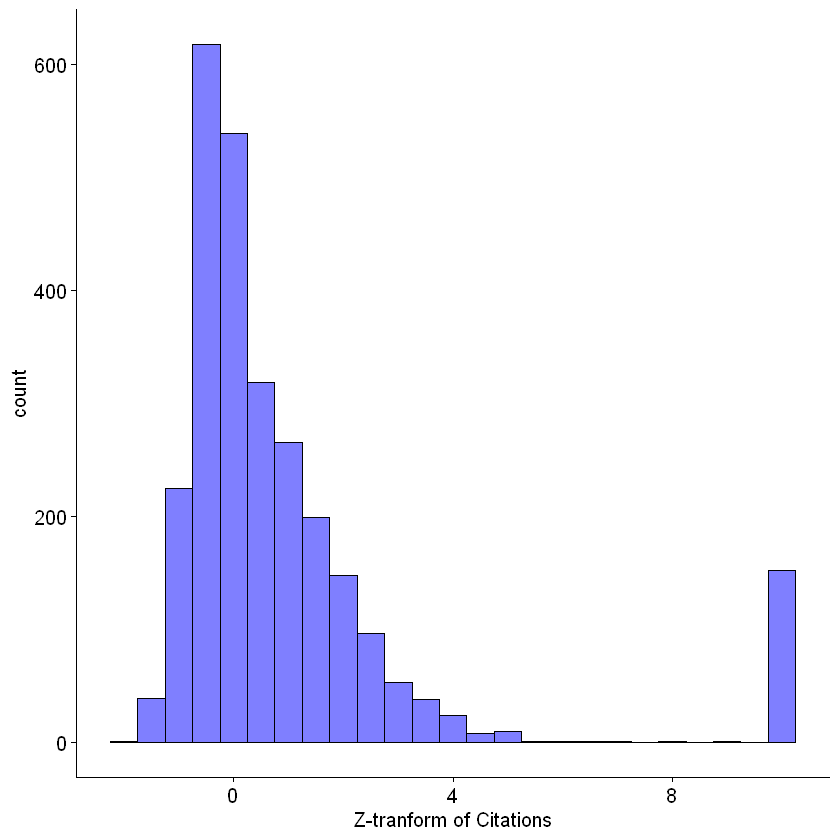

In [5]:
tmp.data <- normed%>%
  mutate(std.pile = ifelse(std > 10, 10, std))
  #filter(Quartile == "Quartile 1")
gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            fill = "blue",
            xlab = "Z-tranform of Citations"
            #add = "mean"
            ) 
  #+xscale("log2", .format = TRUE)

print('mean')
mean(normed$std)
print('median')
median(normed$std)

unique(normed$std)[which.max(tabulate(match(normed$std, unique(normed$std))))]
unique(normed$std)[349:355]

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
print('mode')
getmode(normed$std)

## Histogram normalized data

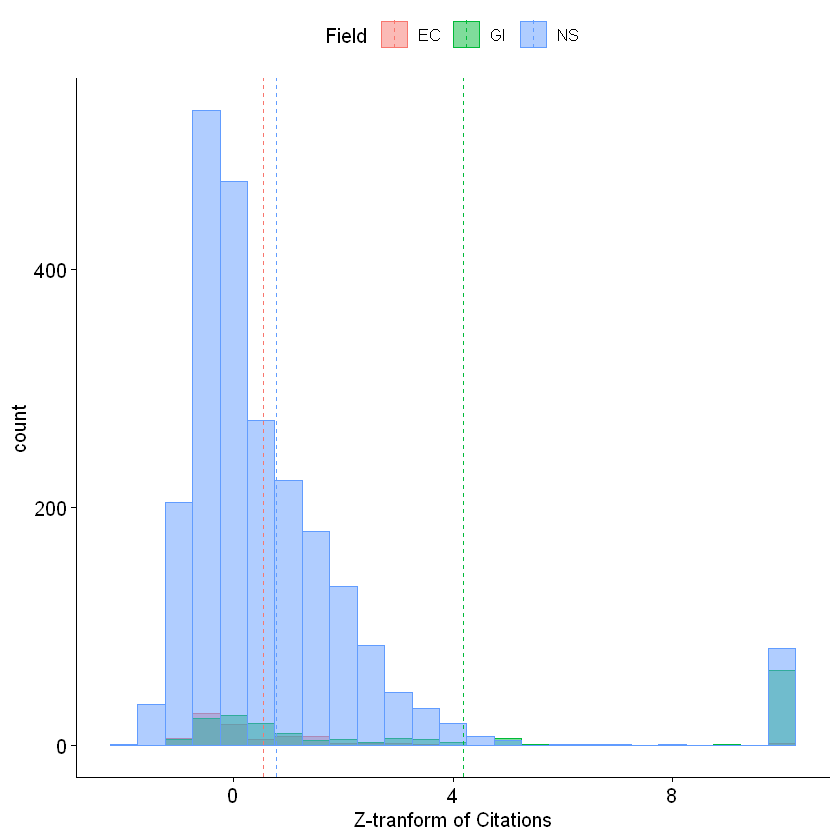

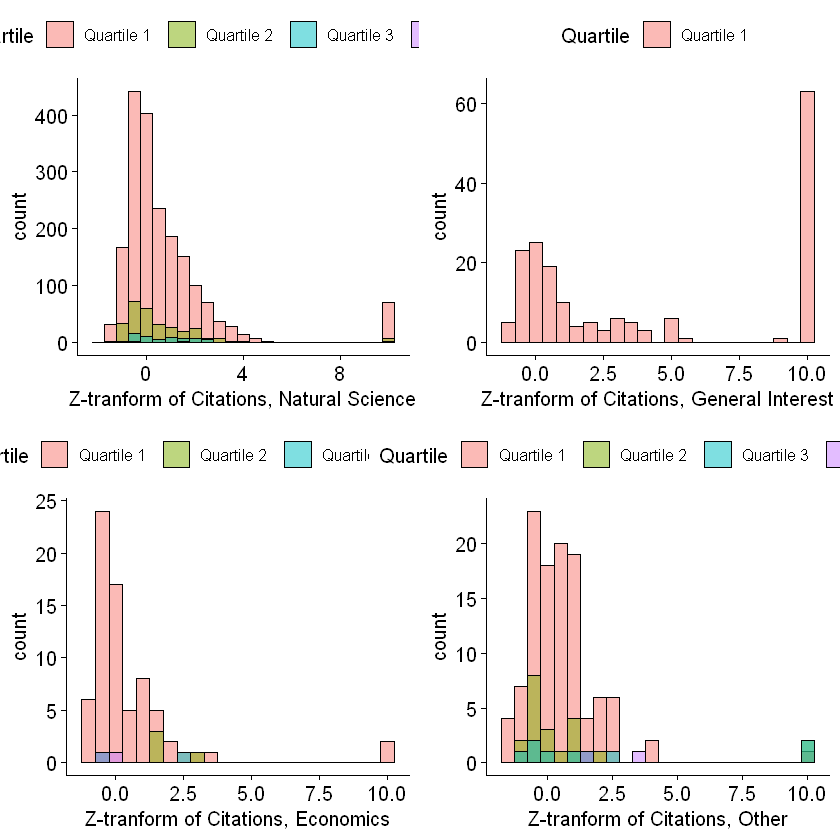

In [6]:
tmp.data <- normed%>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field != "Other")
gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            color = "Field", fill = "Field",
            xlab = "Z-tranform of Citations",
            add = "mean"
            ) #+
 #yscale("log2", .format = TRUE)


tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "NS")
ns.hist <- gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            #color = "blue", 
            fill = "Quartile",
            xlab = "Z-tranform of Citations, Natural Science"
           # add = "mean"
            )
tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "GI")%>%
  filter(Quartile != "Missing")
gi.hist <- gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            #color = "blue", 
            fill = "Quartile",
            xlab = "Z-tranform of Citations, General Interest"
           # add = "mean"
            )
tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "EC")
ec.hist <- gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            #color = "blue", 
            fill = "Quartile",
            xlab = "Z-tranform of Citations, Economics"
           # add = "mean"
            )
tmp.data <- normed %>%
  mutate(std.pile = ifelse(std > 10, 10, std)) %>%
  filter(Field == "Other")
o.hist <- gghistogram(data = tmp.data, x = "std.pile",
            binwidth = 0.5,
            #color = "blue", 
            fill = "Quartile",
            xlab = "Z-tranform of Citations, Other"
           # add = "mean"
            )

plot_grid(ns.hist, gi.hist, ec.hist, o.hist)

## Citations in-depth: Intra- and Cross-Disciplinary
------------------------------------------------------------------------------------
Tables in order:
1. Interdisciplinary set fields
2. Total and average citation by field
3. Count and percentage of cited-by articles by type
4. Count and percentage of cited-by articles by field
5. Count cross-/intra-disciplinary citations per award (only interdisciplinary set)

### Interdiscplinary set

In [7]:
pubs %>% group_by(Field) %>% 
  summarise(count = n()) %>%
  mutate(percent = percent(count/sum(count)))

`summarise()` ungrouping output (override with `.groups` argument)


Field,count,percent
<chr>,<int>,<chr>
EC,81,3.0%
GI,179,6.5%
NS,2335,85.3%
Other,143,5.2%


In [8]:
pubs %>% group_by(Field) %>%
  summarise(avg_CiteScore = mean(CiteScore), total_citations = sum(citation_count), mean = mean(citation_count))

`summarise()` ungrouping output (override with `.groups` argument)


Field,avg_CiteScore,total_citations,mean
<chr>,<dbl>,<int>,<dbl>
EC,3.404074,2766,34.14815
GI,12.209832,47828,267.19553
NS,4.206998,141360,60.53961
Other,2.722867,4453,31.13986


Count and percentage of cited-by articles by type

In [9]:
pubs_cited %>% group_by(Field, CrossIntra) %>%
  summarise(count = n()) %>% 
  mutate(percent = percent(count/nrow(pubs_cited)))

`summarise()` regrouping output by 'Field' (override with `.groups` argument)


Field,CrossIntra,count,percent
<chr>,<chr>,<int>,<chr>
EC,Cross,4155,2.65%
EC,Intra,764,0.49%
GI,Cross,1855,1.185%
GI,Intra,835,0.533%
NS,Cross,26341,16.8%
NS,Intra,117193,74.9%
Other,Cross,4164,2.66%
Other,Intra,1212,0.77%


Count and percentage of cited-by articles by field

In [10]:
pubs_cited %>% group_by(Field, Source) %>%
  summarize(count = n()) %>%
  mutate(percentage = percent(count/sum(count)))

`summarise()` regrouping output by 'Field' (override with `.groups` argument)


Field,Source,count,percentage
<chr>,<chr>,<int>,<chr>
EC,EC,764,15.5%
EC,GI,1581,32.1%
EC,NS,2368,48.1%
EC,Other,206,4.2%
GI,EC,57,2.1%
GI,GI,835,31.0%
GI,NS,1759,65.4%
GI,Other,39,1.4%
NS,EC,1908,1.3%


Count cross-/intra-disciplinary citations per award

In [11]:
peraward = pubs_cited %>% group_by(award_id, Source, CrossIntra) %>%  
  summarize(percentage = n()) %>%
  mutate(percentage = percentage/sum(percentage))
for (source in c("EC", "GI", "NS", "Other")) {
  for (type in c("Cross", "Intra")) {
    cat(source, type,
        percent(mean(peraward[peraward$Source == source & peraward$CrossIntra == type,]$percentage)),
        "\n")
  }
}

`summarise()` regrouping output by 'award_id', 'Source' (override with `.groups` argument)


EC Cross 68.7% 
EC Intra 34.8% 
GI Cross 96.1% 
GI Intra 5.76% 
NS Cross 14.2% 
NS Intra 92.1% 
Other Cross 64.8% 
Other Intra 41.8% 


### Comparator Set

Comp set fields

In [12]:
comp %>% group_by(Field) %>% 
  summarise(count = n()) %>%
  mutate(percent = percent(count/sum(count)))

`summarise()` ungrouping output (override with `.groups` argument)


Field,count,percent
<chr>,<int>,<chr>
EC,1105,0.7%
GI,5766,3.7%
NS,146473,94.3%
Other,1943,1.3%


Total and average citation by field

In [13]:
comp %>% group_by(Field) %>%
  summarise(avg_CiteScore = mean(CiteScore), total_citations = sum(citation_count), mean = mean(citation_count))

`summarise()` ungrouping output (override with `.groups` argument)


Field,avg_CiteScore,total_citations,mean
<chr>,<dbl>,<int>,<dbl>
EC,3.619783,34418,31.14751
GI,11.019969,538751,93.43583
NS,4.470149,3219808,21.98226
Other,3.168950,41287,21.24910


Count and percentage of cited-by articles by type

In [14]:
comp_cited %>% group_by(Field, CrossIntra) %>%
  summarise(count = n()) %>% 
  mutate(percent = percent(count/nrow(comp)))

`summarise()` regrouping output by 'Field' (override with `.groups` argument)


Field,CrossIntra,count,percent
<chr>,<chr>,<int>,<chr>
EC,Cross,3484,2.24%
EC,Intra,1823,1.17%
GI,Cross,2612,1.682%
GI,Intra,1767,1.138%
NS,Cross,71527,46%
NS,Intra,359285,231%
Other,Cross,15891,10.23%
Other,Intra,478,0.31%


Count and percentage of cited-by articles by field

In [15]:
comp_cited %>% group_by(Field, Source) %>%
  summarize(count = n()) %>%
  mutate(percentage = percent(count/sum(count)))

`summarise()` regrouping output by 'Field' (override with `.groups` argument)


Field,Source,count,percentage
<chr>,<chr>,<int>,<chr>
EC,EC,1823,34.4%
EC,GI,409,7.7%
EC,NS,3063,57.7%
EC,Other,12,0.2%
GI,EC,67,1.5%
GI,GI,1767,40.4%
GI,NS,2530,57.8%
GI,Other,15,0.3%
NS,EC,5288,1.2%


## Appendix Table

In [ ]:
app.table = full_data %>%
    group_by("Publication Name"=tools::toTitleCase(publication_name)) %>%
    summarise(Interdisciplinary = sum(Dataset == "Interdisciplinary"),
              Comparator = sum(Dataset == "Comparator"),
              "# Unique Issues" = length(unique(tolower(query))),
              .groups="keep")
app.table
fwrite(app.table, "Appendix_Table_1.csv")